# Libraries

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

# Functions

In [2]:
def gaussian_quadrature(n):
        # n: number of points
        # w: weight 
        # x: point of integration
        
        if n == 1:
            w = np.array([2])
            x = np.array([0])
        elif n == 2:
            w = np.array([1, 1])
            x = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
        elif n == 3:
            w = np.array([5/9, 8/9, 5/9])
            x = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
        elif n == 4:
            w = np.array([ (18-np.sqrt(30))/36, (18+np.sqrt(30))/36, (18+np.sqrt(30))/36, (18-np.sqrt(30))/36 ])
            x = np.array([ -np.sqrt(3/7 + 2/7*np.sqrt(6/5)), -np.sqrt(3/7 - 2/7*np.sqrt(6/5)), np.sqrt(3/7 - 2/7*np.sqrt(6/5)), np.sqrt(3/7 + 2/7*np.sqrt(6/5)) ])
        
        return x, w

# Input data

In [3]:
L = 1                             # Beam length    
q = 100                           # load
nel = 512                         # number of elements
nnos = nel + 1                    # number of nodes   
alldof = np.linspace(1, 1,2*nnos) # all degrees of freedom
kg = np.zeros((2*nnos,2*nnos))    # global stiffness matrix pre-allocation
I = 100                           # inertia
E = 210e9                         # young's modulus   
coord = np.zeros((nnos, 3))       # coordinate matrix pre-allocation
inci = np.zeros((nel, 6))         # incidence matrix pre-allocation
f = np.zeros((2*nnos, 1))         # external load vector

# Coordinate matrix

In [4]:
for i in range(0, nnos):
    coord[i,0] = i + 1      # node number
    coord[i,1] = i*L/nel    # node position
    coord[i,2] = 0
l = coord[1,1] - coord[0,1] # element length

# Incidence matrix

In [5]:
for i in range(0, nel):   
    inci[i,0] = i + 1          # element number
    inci[i,1] = i + 1          # first node
    inci[i,2] = i + 2          # second node
    inci[i,3] = coord[i,1]     # first node coordinate
    inci[i,4] = coord[i+1,1]   # second node coordinate
    inci[i,5] = I              # inertia of beam section

# Boundary conditions

In [6]:
#   bc=[node | degree of freedom | value]
#
#   Degree of freedom 1 --> y
#   Degree of freedom 2 --> oz

bc = np.array([[1,1,0],[1,2,0]])

# Mask stiffness matrix

In [7]:
mask = np.zeros((2*nnos,2*nnos))
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        mask[2*bc[i,0]-2,2*bc[i,0]-2] = 1
    elif bc[i,1] == 2:
        mask[2*bc[i,0]-1,2*bc[i,0]-1] = 1
mask = ma.masked_equal(mask, 1)
mask = ma.mask_rowcols(mask)
mask = (mask==False)

# Mask load vector

In [8]:
maskv = np.zeros(2*nnos)
for i in range(0, np.size(bc,0)):
    if bc[i,1] == 1:
        maskv[2*bc[i,0]-2] = 1
    elif bc[i,1] == 2:
        maskv[2*bc[i,0]-1] = 1
maskv = ma.masked_equal(maskv, 1)
maskv = (maskv==False)

#  Load vector

In [9]:
#   F = [node | degree of freedom | value]
#
#   Degree of freedom 1 --> Fy
#   Degree of freedom 2 --> Mz
def Q(x, q, L):
    Q = q + 3/4*q/L**2*x**2 - 7/4*q/L*x
    return Q

def phi(x, L):
    phi = np.array([[2*x**3/L**3 - 3*x**2/L**2 + 1], [x - 2*x**2/L + x**3/L**2], [3*x**2/L**2 - 2*x**3/L**3], [x**3/L**2 - x**2/L]])
    return phi


n = 3
x,w = gaussian_quadrature(n)
fg = np.zeros((2*nnos,1))

for i in range(nel):
    node1 = inci[i,1]  # first node element
    node2 = inci[i,2]  # second node element

    loc = [2*node1-2,2*node1-1,2*node2-2,2*node2-1]

    coord1 = coord[int(node1) - 1, 1] # node 1 position
    coord2 = coord[int(node2) - 1, 1] # node 2 position

    fe = np.zeros((4,1))   # local load vector 

    Q_ = 0
    for j in range(n):

        epsilon = (coord2 - coord1)/2*x[j] + (coord2 + coord1)/2     
        fe = fe + ((coord2 - coord1)/2)*Q(epsilon  , q, L)*phi(epsilon, L)*w[j] 
    
    fg[[int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] = fg[[int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] + fe

# Global matrix assembly

In [10]:
for i in range(nel):
    node1 = inci[i,1] # first node element
    node2 = inci[i,2] # second node element
    
    # local stiffness matrix
    inertia = inci[i,5]
    ke = E*inertia/l**3*np.array([[12, 6*l, -12, 6*l], [6*l, 4*l**2, -6*l, 2*l**2], [-12, -6*l, 12, -6*l],  [6*l, 2*l**2, -6*l, 4*l**2]])
    
    # localization vector
    loc = [2*node1-2,2*node1-1,2*node2-2,2*node2-1]
    
    # global stiffness matrix 
    kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] = kg[[[int(loc[0])],[int(loc[1])],[int(loc[2])], [int(loc[3])]], [int(loc[0]),int(loc[1]),int(loc[2]),int(loc[3])]] +  ke
    
kg_aux = kg[mask.data]
kg_aux = np.reshape(kg_aux, (2*nnos-np.size(bc,0), 2*nnos-np.size(bc,0)))
f_aux  = fg[maskv.data]

# Displacement

In [11]:
u = np.zeros((2*nnos, 1))
u[maskv.data] = np.linalg.solve(kg_aux, f_aux)
u_ = np.reshape(u,(nnos,2))
displacement = u_[:,0]
rotation = u_[:,1]

# Post-processing

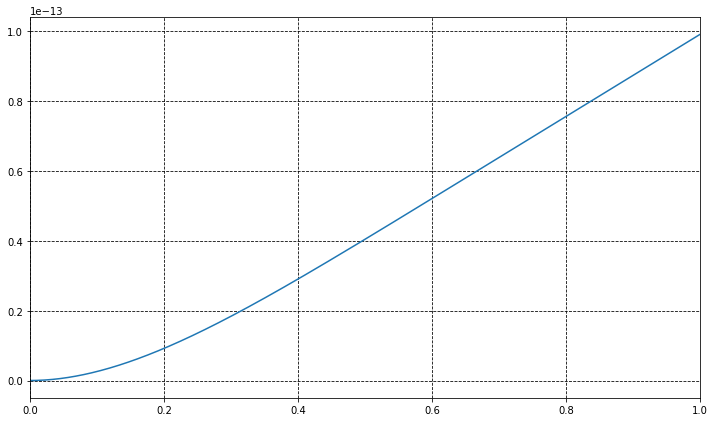

In [13]:
coord[:,2] = displacement
fig, ax = plt.subplots(figsize = (12, 7))

plt.plot(coord[:,1],coord[:,2])
plt.xlim([0,1])
plt.grid(b=True, which='major', color='k', linestyle='--')
fig.savefig('fem_lista_2_Q4.png',dpi=300)                              # save figure as png (dpi = number of pixels)